# Прогнозирование временных рядов при помощи AutoML (на примере фреймворка FEDOT)
#### FEDOT version = 0.3.1

In [ ]:
pip install fedot==0.3.1

[Репозиторий на GitHub](https://github.com/nccr-itmo/FEDOT)

Данный демонстрационный материал был подготовлен [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

Ниже приведен пример прогнозирования временных рядов уровня моря с часовой и суточной дискретностью.

In [26]:
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error

# Plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

In [27]:
# Chain and nodes
from fedot.core.chains.chain import Chain
from fedot.core.chains.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# fedot api
from fedot.api.main import Fedot

Зададим функцию, которая будет рисовать прогноз и выводить значение метрик

In [37]:
def display_results(actual_time_series, predicted_values, len_train_data, y_name = 'Sea level',
                    left_x_border=None):
    """
    Function for drawing plot with predictions and check metrics
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param left_x_border: number of elements to plot on the left part of x-axis
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    if left_x_border is not None:
        plt.xlim(len_train_data - left_x_border, len(actual_time_series) + 20)
    plt.grid()
    plt.show()
    
    mae_value = mean_absolute_error(actual_time_series[len_train_data:], predicted_values)
    print(f'MAE value: {mae_value}')

## Прогнозированние одномерного ряда при помощи AutoML

---

Определим длину прогноза - 250 элементов. Загрузим данные, разделим их на обучение и тест

In [29]:
forecast_length = 250

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))

# Load data from csv file and wrap it into InputData structure
input_data = InputData.from_csv_time_series(task, 
                                            'ts_sea_level_day.csv', 
                                            target_column='Level')

# Divide into train and test 
train_data, test_data = train_test_data_setup(input_data)

### Временной ряд №1
#### Запуск идентификации модели в автоматизированном режиме

In [30]:
composer_params = {'max_depth': 4,
                   'max_arity': 3,
                   'pop_size': 20,
                   'num_of_generations': 20,
                   'learning_time': 2,
                   'preset': 'light_tun'}

Основная часть - инициализируем модель. Ищем лучшее решение а автоматическом режиме, и даём прогноз

In [31]:
# Init model for the time series forecasting
model = Fedot(problem='ts_forecasting', task_params=task.task_params,
              composer_params=composer_params)

# Run AutoML model design in the same way
chain = model.fit(features=train_data)

# Use model to obtain forecast
forecast = model.predict(features=test_data)

Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'ar', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 2 min
Model composition started
Hyperparameters tuning started
Default loss function was set
Hyperparameters optimization start
  2%|▉                                              | 21/1000 [01:00<47:11,  2.89s/trial, best loss: 0.081930228008726]
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 0.082 equal or smaller than initial (+ 5% deviation) 0.084
Model composition finished


Визуализация прогноза

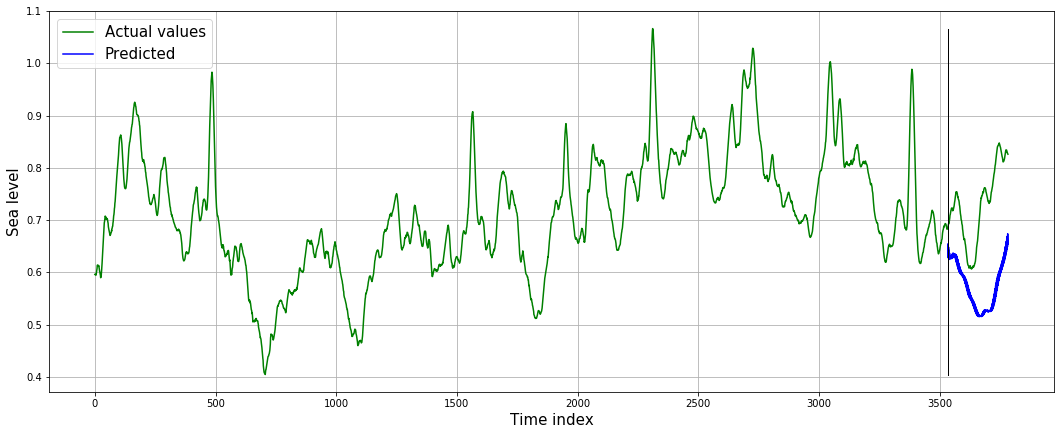

MAE value: 0.15243180184631655


In [32]:
display_results(input_data.target, forecast, len(train_data.features))

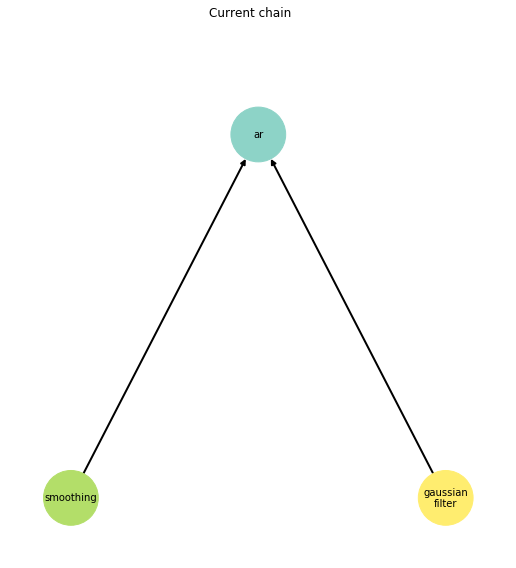

In [33]:
chain.show()

---

### Временной ряд №2

Ниже мы будем подготавливать модель так, чтобы она формировала прогноз на 72 часа

Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'ar', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 2 min
Model composition started
Hyperparameters tuning started
Default loss function was set
Hyperparameters optimization start
  6%|██▉                                           | 64/1000 [01:00<14:38,  1.07trial/s, best loss: 17.372345158866604]
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 17.372 equal or smaller than initial (+ 5% deviation) 23.253
Model composition finished


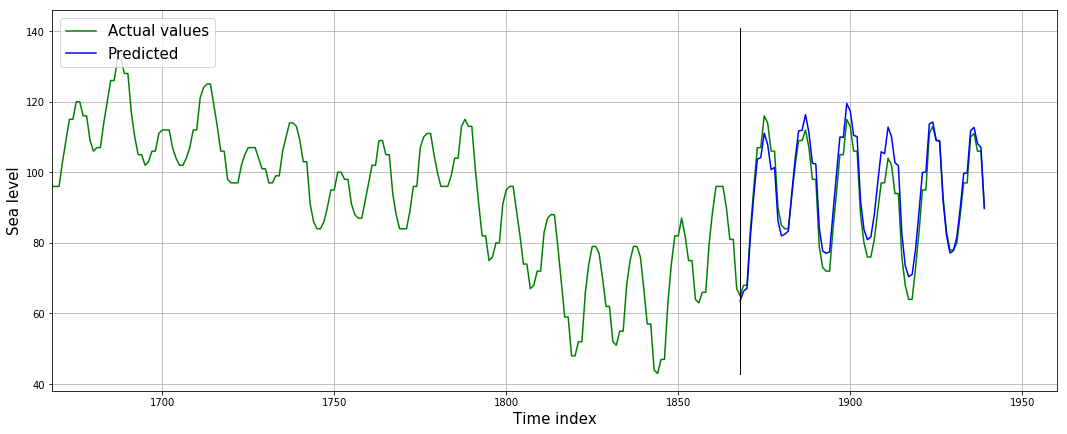

MAE value: 3.917149856766984


In [39]:
forecast_length = 72
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))
input_data = InputData.from_csv_time_series(task, 
                                            'ts_sea_level_hour.csv', 
                                            target_column='sea_height')

# Divide into train and test 
train_data, test_data = train_test_data_setup(input_data)

# Init model for the time series forecasting
model = Fedot(problem='ts_forecasting', task_params=task.task_params,
              composer_params=composer_params)

# Run AutoML model design in the same way
chain = model.fit(features=train_data)

# Use model to obtain forecast
forecast = model.predict(features=test_data)

display_results(input_data.target, forecast, 
                len(train_data.features), left_x_border=200)

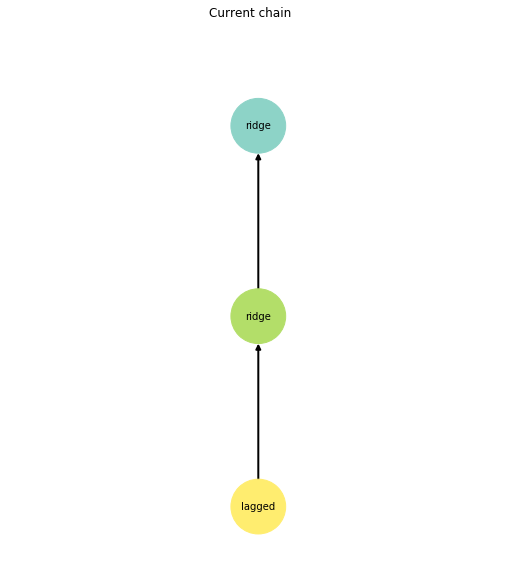

In [40]:
chain.show()

## Многомерный временной ряд

Можно использовать "соседний" временной ряд как экзогенный.

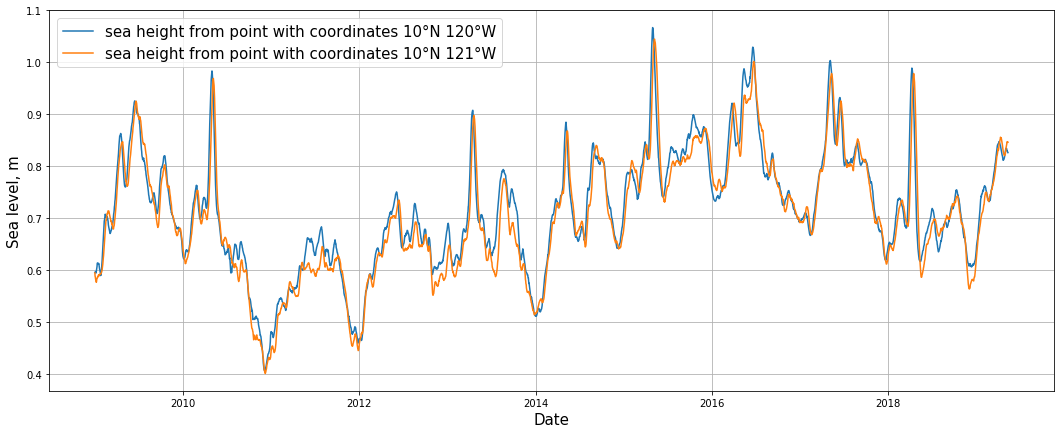

In [36]:
df = pd.read_csv('ts_sea_level_day.csv', parse_dates=['Date'])

# Plot two time series
plt.plot(df['Date'], df['Level'], label = 'sea height from point with coordinates 10°N 120°W')
plt.plot(df['Date'], df['Neighboring level'], label = 'sea height from point with coordinates 10°N 121°W')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Sea level, m', fontsize = 15)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

Во всех примерах ниже мы не будем использовать механиз идентификации структуры пайплайна (композирование), а при необходимости будем обращаться только к блоку настройки гиперпараметров. 

In [41]:
# Specify forecast length
len_forecast = 250
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=len_forecast))

# Got train, test parts, and the entire data
true_values = np.array(df['Level'])
train_array = true_values[:-len_forecast]
test_array = true_values[-len_forecast:]

# Data for lagged transformation
train_lagged = InputData(idx=np.arange(0, len(train_array)),
                         features=train_array,
                         target=train_array,
                         task=task,
                         data_type=DataTypesEnum.ts)
start_forecast = len(train_array)
end_forecast = start_forecast + len_forecast
predict_lagged = InputData(idx=np.arange(start_forecast, end_forecast),
                           features=train_array,
                           target=test_array,
                           task=task,
                           data_type=DataTypesEnum.ts)

In [42]:
exog_arr = np.array(df['Neighboring level'])
exog_train = exog_arr[:-len_forecast]
exog_test = exog_arr[-len_forecast:]

# Data for exog operation
train_exog = InputData(idx=np.arange(0, len(exog_train)),
                       features=exog_train,
                       target=train_array,
                       task=task,
                       data_type=DataTypesEnum.ts)
start_forecast = len(exog_train)
end_forecast = start_forecast + len_forecast
predict_exog = InputData(idx=np.arange(start_forecast, end_forecast),
                          features=exog_test,
                          target=test_array,
                          task=task,
                          data_type=DataTypesEnum.ts)

In [43]:
from fedot.core.data.multi_modal import MultiModalData

train_dataset = MultiModalData({
    'lagged': train_lagged,
    'exog_ts_data_source': train_exog
})

predict_dataset = MultiModalData({
    'lagged': predict_lagged,
    'exog_ts_data_source': predict_exog
})

In [44]:
# Create a chain with different data sources in th nodes 
node_lagged = PrimaryNode('lagged')
node_exog = PrimaryNode('exog_ts_data_source')
node_ridge = SecondaryNode('ridge', nodes_from=[node_lagged, node_exog])
exog_chain = Chain(node_ridge)

# Fit it
exog_chain.fit(train_dataset)

# Predict
predicted = exog_chain.predict(predict_dataset)
predicted_values = np.ravel(np.array(predicted.predict))

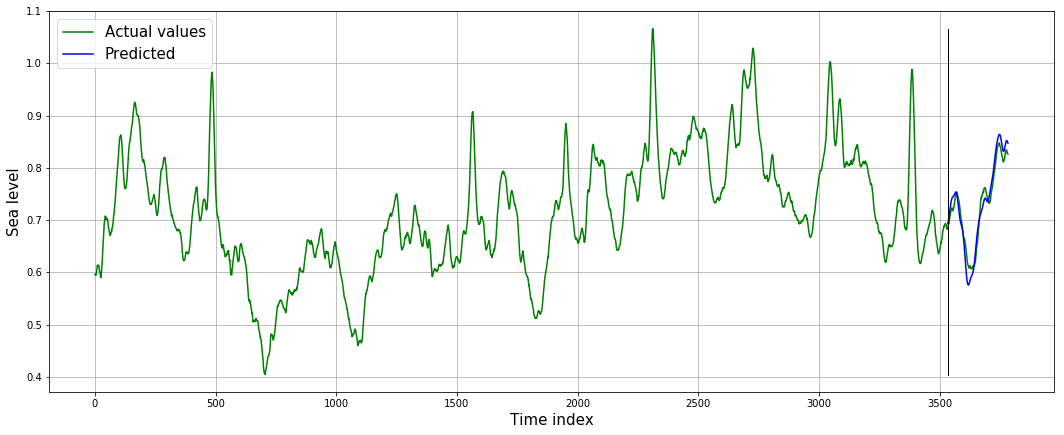

MAE value: 0.016815423036884648


In [45]:
display_results(true_values, predicted_values, len(train_array))

Прогноз отличный!

## Применение операции "разложение" для раздельного прогнозирования компонент

<img src="images/err_mod.png" width="700"/>

In [64]:
def get_refinement_chain(lagged):
    """ Create 4-level chain with decompose operation """

    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': lagged}
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged])
    node_decompose = SecondaryNode('decompose', nodes_from=[node_lagged, node_lasso])
    node_dtreg = SecondaryNode('dtreg', nodes_from=[node_decompose])
    node_dtreg.custom_params = {'max_depth': 5}

    # Combining branches with different targets (T and T_decomposed)
    final_node = SecondaryNode('ridge', nodes_from=[node_lasso, node_dtreg])

    chain = Chain(final_node)
    return chain


def get_non_refinement_chain(lagged):
    """ Create 4-level chain without decompose operation """

    node_lagged = PrimaryNode('lagged')
    node_lagged.custom_params = {'window_size': lagged}
    node_lasso = SecondaryNode('lasso', nodes_from=[node_lagged])
    node_dtreg = SecondaryNode('dtreg', nodes_from=[node_lagged])
    node_dtreg.custom_params = {'max_depth': 5}
    final_node = SecondaryNode('ridge', nodes_from=[node_lasso, node_dtreg])

    chain = Chain(final_node)
    return chain

Снова загрузим временной ряд №2

In [69]:
forecast_length = 72
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))
input_data = InputData.from_csv_time_series(task, 
                                            'ts_sea_level_hour.csv', 
                                            target_column='sea_height')

# Divide into train and test 
train_data, test_data = train_test_data_setup(input_data)

В функции fit_predict ниже реализована настройка гиперпараметров в цепочке. Алгоритм настройки гиперпараметров можно продемонстрировать на анимации ниже:

<img src="./images/chain_tuning.gif" width="500"/>

In [70]:
def fit_predict(chain, train, test):
    # Tune this chain
    chain = chain.fine_tune_all_nodes(loss_function=mean_absolute_error,
                                      loss_params=None,
                                      input_data=train,
                                      iterations=30)
    
    chain.fit(train)

    # Make prediction
    output = chain.predict(test)
    forecast = np.ravel(np.array(output.predict))
    
    return forecast

refinement_chain = get_refinement_chain(lagged=40)
non_refinement_chain = get_non_refinement_chain(lagged=40)

refinement_forecast = fit_predict(refinement_chain, train_data, test_data)
non_refinement_forecast = fit_predict(non_refinement_chain, train_data, test_data)

Start tuning of primary nodes
Hyperparameters optimization start
Fit chain from scratch
100%|█████████████████████████████████████████████████| 30/30 [02:34<00:00,  5.14s/trial, best loss: 14.20015751668975]
Fit chain from scratch
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 14.200 equal or smaller than initial (+ 5% deviation) 22.253
Tuning was finished
Trained operation cache is not actual because you are using new dataset for training. Parameter use_cache value changed to False
Start tuning of primary nodes
Hyperparameters optimization start
Fit chain from scratch
100%|████████████████████████████████████████████████| 30/30 [02:42<00:00,  5.40s/trial, best loss: 15.038314391052236]
Fit chain from scratch
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 15.038 equal or smaller than initial (+ 5% deviation) 22.652
Tuning was finished
Trained operation cache is not actual because you are using

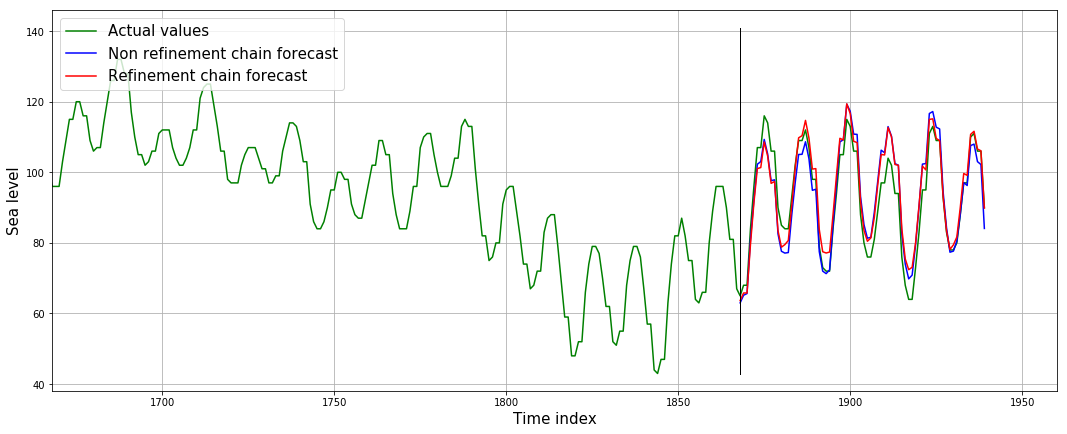

Non refinement chain MAE value: 4.577496793301813
Refinement chain MAE value: 4.281990569666761


In [73]:
len_train_data = len(train_data.target)

plt.plot(np.arange(0, len(input_data.target)), 
         input_data.target, label = 'Actual values', c = 'green')
plt.plot(np.arange(len_train_data, len(input_data.target)), 
         non_refinement_forecast, label = 'Non refinement chain forecast', c = 'blue')
plt.plot(np.arange(len_train_data, len(input_data.target)), 
         refinement_forecast, label = 'Refinement chain forecast', c = 'red')

# Plot black line which divide our array into train and test
plt.plot([len_train_data, len_train_data],
         [min(input_data.target), max(input_data.target)], c = 'black', linewidth = 1)
plt.ylabel('Sea level', fontsize = 15)
plt.xlabel('Time index', fontsize = 15)
plt.legend(fontsize = 15, loc='upper left')
plt.xlim(len_train_data - 200, len(input_data.target) + 20)
plt.grid()
plt.show()

mae_value = mean_absolute_error(input_data.target[len_train_data:], non_refinement_forecast)
print(f'Non refinement chain MAE value: {mae_value}')
mae_value = mean_absolute_error(input_data.target[len_train_data:], refinement_forecast)
print(f'Refinement chain MAE value: {mae_value}')